In [149]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import random

# Connecting physics to machine learning through variational priniple
(Adapted from Jaan Altosaar's blog entry)

This blog entry is quite remarkable as it illustrates the connection between statistical physics and machine learning. In order to parse it and understand the concepts, we will write some simple python code as we go along.

## Modelling a 2-D Ising Lattice
First step is to model a 2-D Ising magnet. This is our toy system to understand these concepts. We will create a class for Ising lattices using numpy arrays.

In [180]:
class IsingLattice(object):
    """Class for modeling 2-D ising lattices.
    """
    def __init__(self, dims=None, interaction_strength=1.0, magnetic_field=0.0):
        """Initialize a 2-D Ising lattice.
        
        Parameters
        ----------
        dims : list, optional
            Number of spins in each dimension where only two dimensions are allowed
        interaction_strength : float, optional
            Pair-wise interaction strength, Default=1.0
        magnetic_field : float, optional
            Value of external magnetic field, Default=0.0

        Examples
        --------
        >>> ising_64 = IsingLattice(8, 8)
        >>> ising_16 = IsingLattice()

        Notes
        -----
        No upper-bound set up for the size of lattice, but unusually large lattices
        would be problematic for analytical solution of partition function.
        """

        if dims is None:
            dims = [4, 4]
        else:
            assert len(dims) == 2, "Only 2-D lattice can be modelled with this class."
            assert dims[0] != 0 or dims[1] != 0, "Only non-zero size allowed."
        self.dims = dims
        self.interaction_strength = interaction_strength
        self.magnetic_field = magnetic_field
        # Initialize lattice with all spins set to +1
        self.lattice = np.ones(self.dims, dtype="float")
        # randomly flip spins to generate initial an configuration
        for i in xrange(self.dims[0]):
            for j in xrange(self.dims[1]):
                if random.random() < 0.5:
                    self.lattice[i, j] *= -1.0
        
    def get_nearest_nbrs(self, pos):
        """Obtain nearest neighbor spins for a spin at a given position in lattice.
        
        Parameters
        ----------
        pos : list
            Position indices of the spin.
        """
        indices = []
        assert len(pos) == self.lattice.ndim, "Mismatch in dimensions."
        if pos[0] >= self.dims[0] or pos[1] >= self.dims[1]:
            raise ValueError("Index must be within the lattice of size %i x %i" % 
                             (self.dims[0], self.dims[1]))
        else:
            i, j = pos
            nbrs = [[(i - 1)%self.dims[0], j], [(i + 1)%self.dims[0], j],
                    [i, (j - 1)%self.dims[0]], [i, (j + 1)%self.dims[1]]]
            return nbrs
    
    def hamiltonian(self):
        """Returns hamiltonian of the system based on current configuration.
        
        Notes
        -----
            This should not be used when we are interested in differences in energies
            resulting from flipping a single spin. In those cases, no need to loop over
            all spins, just calculate new interactions with nearest neighbors of flipped spin.
        """
        interaction_energy = 0.0
        sum_spins = 0.0
        for i in xrange(self.dims[0]):
            for j in xrange(self.dims[1]):
                s_ij = self.lattice[i, j]
                sum_spins += s_ij
                interaction_energy -= s_ij * (self.lattice[i, (j+1)%self.dims[0]] + self.lattice[(i+1)%self.dims[0], j])
        hamiltonian = (self.interaction_strength * interaction_energy) - (self.magnetic_field * sum_spins) 
        return hamiltonian
    
    
    def sample_observables(self):
        """Sample current state of the system by obtaining average energy and magnetization
        
        Returns
        -------
        (avg_energy, avg_spin) : tuple
            A tuple with values of average energy and average spin in the current config
        """
        avg_energy = self.hamiltonian() / (self.dims[0]*self.dims[1]) 
        avg_spin = np.sum(self.lattice)/(self.dims[0]*self.dims[1])
        return avg_energy, avg_spin

### Some helpful notes for this example:

We consider a 2D square latex. Using default values for parameter $J$ and $H$, the hamiltonian is reduced to:

$H = -\sum_{<ij>}s_is_j$

A given spin $s_i$ is either +1 or -1. $<ij>$ denote unique nearest neighbor pairs. In order to obtain the number of unique nearest neighbor pairs, we need to know the coordination  number $z$, which is just the number of nearest neighbors for each spin. For a 2D square lattic, this number is 4. But each spin contributes on 2 unique pairs. Hence the total number of unique nearest neighbor pairs are $\frac{Nz}{2}$, where $z = 4$ in this case. 

The probability of a particular configuration is given by:

$P(x) = \frac{exp[-\beta H(s_1, \cdots, s_n)]}{\sum_{s_1=-1}^{1} \cdots \sum_{s_n=-1}^{1}{exp[-\beta H(s_1, \cdots, s_n)]}}$

Also note that the product $s_is_j$ is 1 when both spins have the same orientation and -1 when they are opposite. The total energy of the system is minimum when all spins are the same sign.

Let's also bring in an observable, a measurable property of each configuration. We will use _Magnetization_, $M$, which is defined as:

$M(s_1, \cdots, s_n) = \frac{1}{N}\sum_{i=1}^N s_i$

The quantity $M(x)$ is simply the average orientation in a configuration. It is an interesting quantity because we expect that the thermal energy is expected to affect the orientations of individual flips, thereby affecting this quantity as well. The ensemble average for this quantity is given by:

$\langle M \rangle = \frac{\sum_{s_1 = -1}^1 \cdots \sum_{s_n = -1}^ 1 [\frac{1}{N}\sum_i s_i] exp[-\beta H(s_1, \cdots, s_n)]}{\sum_{s_1=-1}^{1} \cdots \sum_{s_n=-1}^{1}{exp[-\beta H(s_1, \cdots, s_n)]}}$.

<M> is an order parameters that defines phase transition.

In [121]:
# for debugging
test = [[-1, -1, -1, -1], [-1, 1, 1, -1], [-1, 1, 1, -1], [-1, 1, -1, 1]]
debug_lattice = np.array(test, dtype=float)


# Monte Carlo sampling of the 2-D Ising Magnet

We seem to have a reasonable first implementation of an Ising magnet, Let's take it for a spin (no pun intended). 

In [148]:
def simulate(magnet, temp=1.0, n_runs=3, n_cycles=10000, sampling_freq=100, write_data=False):
    """Simulate an Ising magnet at a given tempeature.
    
    Parameters
    ----------
    magnet : IsingLattice
        An IsingLattice object
    temp : float
        Value of temperature at which simulation is performed
    n_runs : int
        Number of repetitions of the Monte Carlo simulation
    n_cycles : int
        Number of cycles in each MC run
    sampling_freq : int
        Number of samples to use for calculating observables
    write_data : bool, optional
        Write various data to disk (functionality to be added later)
    
    Returns
    -------
    E_per_spin : numpy.ndarray, dims=(n_runs, n_cycles/sampling_freq)
        Energy per spin recorded for each sample
    M_per_spin : numpy.ndarray
        Magnetization per spin recorded for each sample
    """
    M, N = magnet.dims[0],  magnet.dims[1]
    n_spins = M * N

    kb = 1.0
    beta = 1.0/(kb * temp)
    # initialize arrays to store data during simulation
    E_per_spin = np.zeros((n_runs, n_cycles/sampling_freq))
    M_per_spin = np.zeros((n_runs, n_cycles/sampling_freq))
    print "Current simulation running at Temperature %g." % temp
    for rep in xrange(n_runs):
        n_samples = 0
        for cycle in xrange(n_cycles):
            for attempt in xrange(n_spins):
                i, j = random.randint(0, M - 1), random.randint(0, N - 1)
                update_interactions = 0.0
                nearest_nbrs = magnet.get_nearest_nbrs([i, j])
                for nbr in nearest_nbrs:
                    update_interactions += magnet.lattice[nbr[0], nbr[1]]
                dE = -2.0 * magnet.lattice[i, j] * update_interactions
                # figure out sign of exponent
                # if i need not evaluate boltzman factor
                boltzmann_factor = np.exp(beta*dE)
                x = random.random()
                if x < boltzmann_factor:
                    magnet.lattice[i, j] *= -1.0
            if not cycle % sampling_freq:
                current_avg_e, current_avg_s = magnet.sample_observables()
                #print "%i %f %f" % (trial, current_avg_s, current_avg_e)
                E_per_spin[rep, n_samples] = current_avg_e
                M_per_spin[rep, n_samples] = current_avg_s
                n_samples += 1

    return E_per_spin, M_per_spin

In [178]:
ising = IsingLattice([20, 20])
temperatures = np.arange(0.0, 5.0, 0.2)
E = np.zeros((temperatures.shape[0]))
M = np.zeros((temperatures.shape[0]))
errors_E = np.zeros((E.shape[0]))
errors_M = np.zeros((M.shape[0]))
for index, T in enumerate(temperatures):
    runs = 3
    data_e, data_m = simulate(ising, temp=T, n_runs=runs, n_cycles=10000, sampling_freq=100)
    E[index] = np.mean(data_e)
    M[index] = np.mean(data_m)
    errors_E[index] = np.std(data_e)
    errors_M[index] = np.std(data_m)


Current simulation running at Temperature 1.
Current simulation running at Temperature 2.
Current simulation running at Temperature 3.
Current simulation running at Temperature 4.
Current simulation running at Temperature 5.


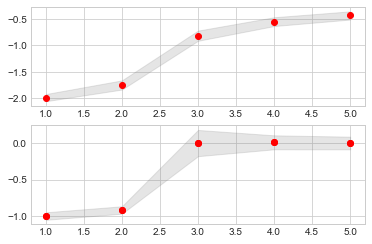

In [179]:
fig, ax = plt.subplots(2, sharex='row')
ax[0].plot(temperatures, E, 'or')
ax[1].plot(temperatures, M, 'or')
ax[0].fill_between(temperatures, E - errors_E, E + errors_E,
                 color='gray', alpha=0.2)
ax[1].plot(temperatures, M, 'or')
ax[1].fill_between(temperatures, M - errors_M, M + errors_M,
                 color='gray', alpha=0.2)


# First look at the Ising model and statsitical inference
Here we will go through some basic maths that covers our understanding of how Ising mdoel illustrates ideas of statsitical inference.

Our model consists of $N_{spin}$ random variables, where $N_{spin}$ is the number of spins in our lattice. Let $X$ describe the current configuration of the lattice, where $X = \left\{X_0, X_1, \cdots, X_{N_{spin}}\right\}$. Let's be clear that $X$ is just a set of random variables. A given realization of $X$ is denoted as $x = \left\{x_0, x_1, \cdots, x_{N_{spin}}\right\}$, where $x_i \in \{+1, -1\}$. 

The probability distribution 